In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import scipy
import seaborn as sns
from datetime import datetime, timedelta

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

In [2]:
from feed_forward_network import FeedForwardNetwork
from preprocessing import *
from utils import *
from features import *

In [3]:
raw_data = pd.read_csv('consumption_and_temperatures.csv')
raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'])

In [4]:
seq_len = 0
scale_output=True
target_column = 'NO1_consumption'

In [5]:
features_to_add = [
    (   
        pick_location_data,
        { 'loc': [1] }
    ),
    (
        add_season_columns, 
        {}
    ),
    (
        shift_data, 
        {
            "shift_max": 10,
            "column_to_shift": "NO1_temperature",
            "new_column_name": "temp"
        }
    ),
    (
        shift_data, 
        {   
            "shift_min": 24,
            "shift_max": 24,
            "column_to_shift": "NO1_consumption",
            "new_column_name": "consum"
        },
    ),
    # (
    #     change_timestamp_to_sin,
    #     {}
    # ),
    (
        add_hour_columns,
        {}
    ),
    (
        get_yesterday_target_mean,
        {'target': 'NO1_consumption'}
    )
]

In [6]:
for feature in features_to_add:
    print(feature)

(<function pick_location_data at 0x168555360>, {'loc': [1]})
(<function add_season_columns at 0x1685551b0>, {})
(<function shift_data at 0x1685553f0>, {'shift_max': 10, 'column_to_shift': 'NO1_temperature', 'new_column_name': 'temp'})
(<function shift_data at 0x1685553f0>, {'shift_min': 24, 'shift_max': 24, 'column_to_shift': 'NO1_consumption', 'new_column_name': 'consum'})
(<function add_hour_columns at 0x168555240>, {})
(<function get_yesterday_target_mean at 0x168555480>, {'target': 'NO1_consumption'})


In [7]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), (scalerInputMethod, scalerOutputMethod), (df_target, time_delta_shifting) = general_preprocessing(
        raw_data, 
        features_to_add=features_to_add,
        seq_len=seq_len,
        forecast_len=100+24,
        # test_start_index=len(raw_data) * 3 //4,
        scale_output=scale_output
    )

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
            ...     
58459    5504.451783
58460    5485.346413
58461    5466.084820
58462    5446.085089
58463    5428.106471
Name: NO1_consumption_yesterday_mean, Length: 58464, dtype: float64
FEATURES:
 Index(['NO1_temperature', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'temp_1_previous', 'temp_2_previous',
       'temp_3_previous', 'temp_4_previous', 'temp_5_previous',
       'temp_6_previous', 'temp_7_previous', 'temp_8_previous',
       'temp_9_previous', 'temp_10_previous', 'consum_24_previous', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'NO1_consumption_yesterday_mean'],
      dtype='object')


/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[features_to_scale] = scalerInputMethod.fit_transform(X_train[features_to_scale].values) if not is_scaler_fitted else  scalerInputMethod.transform(X_train[features_to_scale].values)
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/arthurtestard/ntnu_code/deep_learning/project_2/preprocessing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [8]:
X_train.shape, y_train.shape

(torch.Size([40908, 41]), torch.Size([40908, 1]))

In [9]:
model = FeedForwardNetwork(input_size=X_train.shape[1])

In [10]:
lr = 0.01
num_epochs=100

In [11]:
loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=lr)

In [12]:
model, losses, val_loss, opt = fit(
    model, 
    train_set=(X_train, y_train),
    val_set=(X_val, y_val),
    opt=opt,
    loss_func=loss_func,
    num_epochs=num_epochs
)

100%|██████████| 100/100 [00:00<00:00, 114.73it/s]


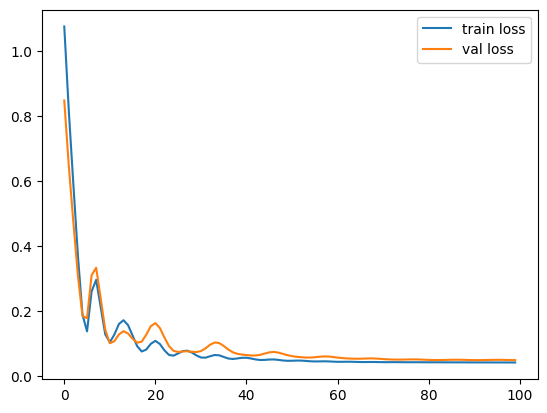

In [13]:
plt.plot(losses, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()

In [14]:
y_test, y_pred = predict(model, scalerOutputMethod, (X_test, y_test))

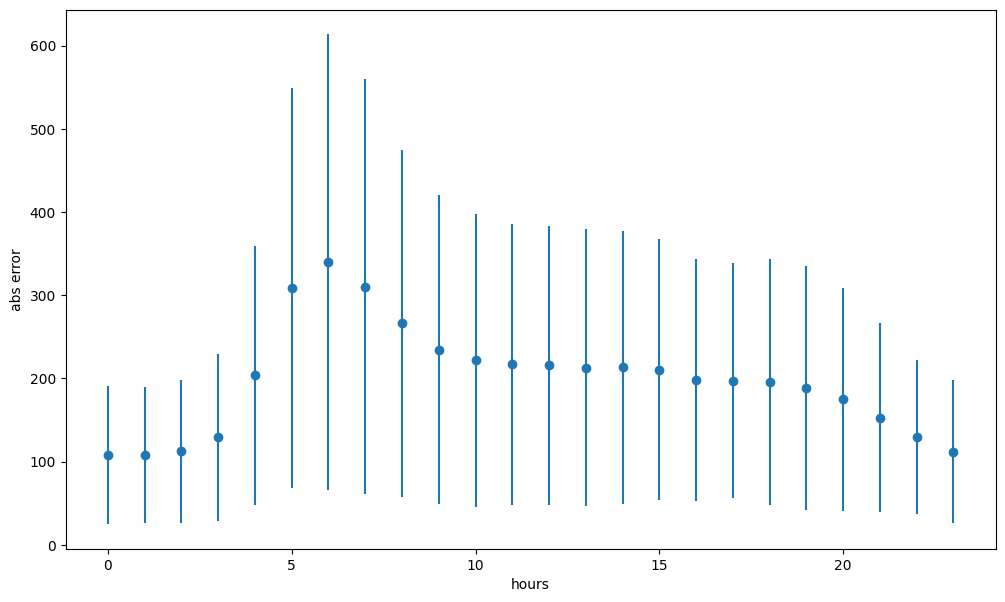

In [15]:
plot_error_by_hour_for_test_set(y_test, y_pred)

/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


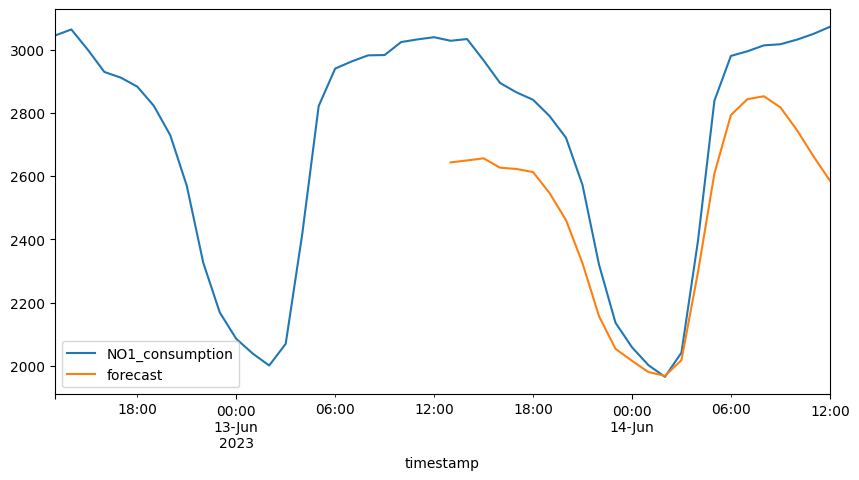

/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


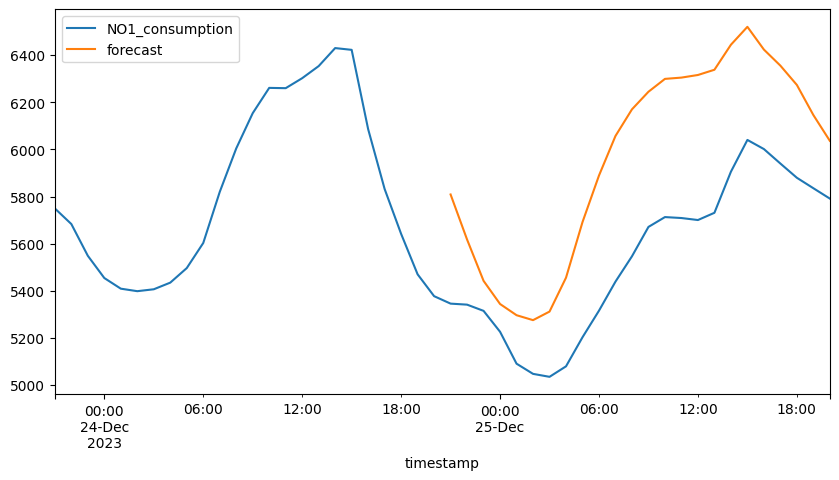

/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


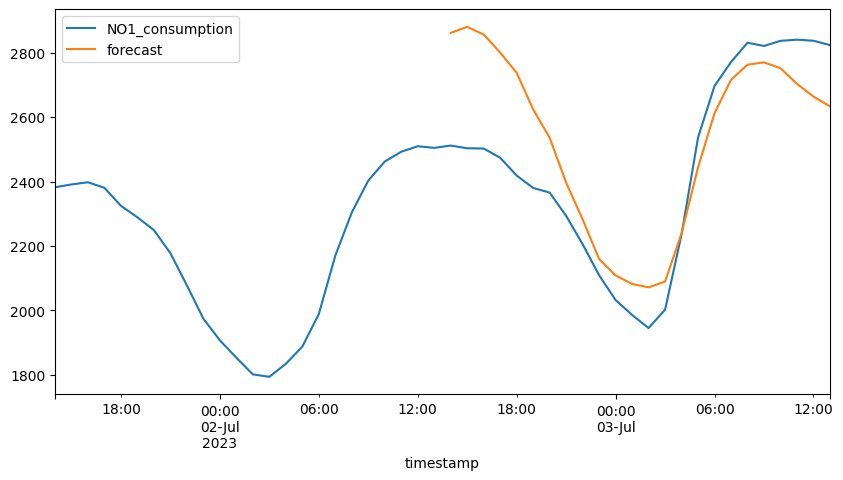

/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


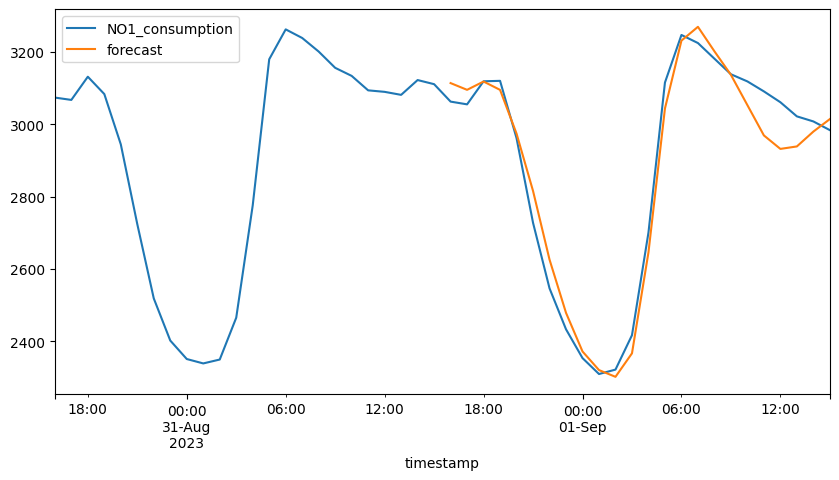

/Users/arthurtestard/ntnu_code/deep_learning/project_2/utils.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['forecast'] = df_forecast['consumption_forecast']


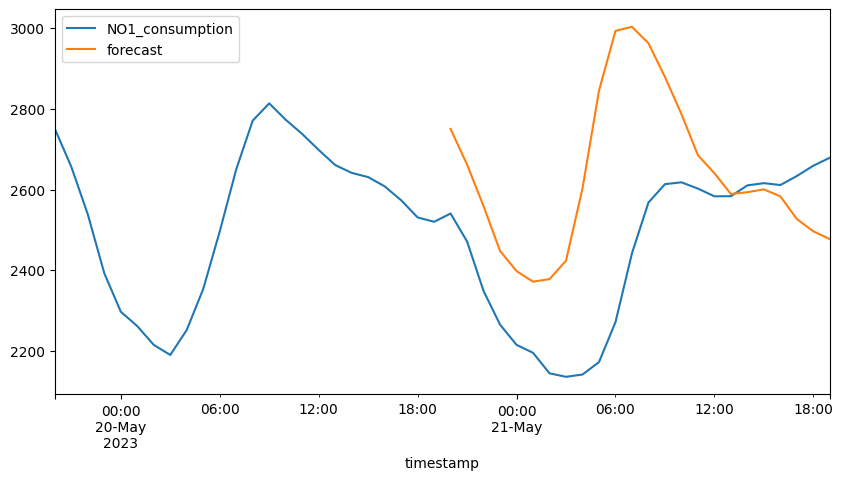

In [16]:
for k in range(5):
    make_forecast(y_pred=y_pred, df_target=df_target, seq_len=seq_len, time_delta_shifting=time_delta_shifting)